# Import Libraries 

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from scipy.stats import chi2
#np.random.seed(10)
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import load_digits

# Load Two Raw Dataframes

In [164]:
# Load the date in timedate format
price_demand = pd.read_csv('price_demand_data.csv', parse_dates = ['SETTLEMENTDATE'], dayfirst = True)
weather = pd.read_csv('weather_data.csv', parse_dates = ['Date'], dayfirst = True)
display(price_demand)
display(weather)

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICECATEGORY
0,VIC1,2021-01-01 00:30:00,4179.21,LOW
1,VIC1,2021-01-01 01:00:00,4047.76,LOW
2,VIC1,2021-01-01 01:30:00,3934.70,LOW
3,VIC1,2021-01-01 02:00:00,3766.45,LOW
4,VIC1,2021-01-01 02:30:00,3590.37,LOW
...,...,...,...,...
11659,VIC1,2021-08-31 22:00:00,4861.91,MEDIUM
11660,VIC1,2021-08-31 22:30:00,4748.74,MEDIUM
11661,VIC1,2021-08-31 23:00:00,4620.09,MEDIUM
11662,VIC1,2021-08-31 23:30:00,4834.00,MEDIUM


,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-01-01,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
1,2021-01-02,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2,2021-01-03,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
3,2021-01-04,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
4,2021-01-05,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2021-08-27,4.6,13.6,0.0,1.2,3.8,SSW,15.0,12:18,7.7,...,7,,Calm,1020.0,12.8,65,7.0,SSE,7,1017.4
239,2021-08-28,5.3,17.8,0.0,1.6,9.6,N,39.0,13:14,9.1,...,1,N,7,1018.6,17.4,31,3.0,NNW,24,1013.5
240,2021-08-29,9.1,16.2,0.6,6.4,4.3,NNE,33.0,1:50,10.6,...,7,N,13,1011.4,12.8,84,7.0,S,6,1010.4
241,2021-08-30,6.4,17.6,4.0,1.4,7.4,NNW,50.0,14:04,11.1,...,7,N,15,1016.1,16.8,45,1.0,NNW,28,1013.2


# Data preparation

In [165]:
# Replace PRICECATEGORY values with Numeric values in new column PRICE_NUMERIC
price_demand['PRICECATEGORY'].replace( {'LOW' : 0, 'MEDIUM' : 1, 'HIGH' : 2, 'EXTREME': 3 }, inplace = True)

# Extract Date and Time seperately from SETTLEMENTDATE in date time format
price_demand['Date'] = pd.to_datetime(price_demand['SETTLEMENTDATE'].dt.date)
price_demand['Time'] = price_demand['SETTLEMENTDATE'].dt.time


# Including daily time duration from 00:30(e.g - 01-01-2021) - 0.00(e.g - 02-01-2021) involves every 48 rows of 30-minute time slots.

price_demand['group_key'] = price_demand.index // 48
price_demand

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICECATEGORY,Date,Time,group_key
0,VIC1,2021-01-01 00:30:00,4179.21,0,2021-01-01,00:30:00,0
1,VIC1,2021-01-01 01:00:00,4047.76,0,2021-01-01,01:00:00,0
2,VIC1,2021-01-01 01:30:00,3934.70,0,2021-01-01,01:30:00,0
3,VIC1,2021-01-01 02:00:00,3766.45,0,2021-01-01,02:00:00,0
4,VIC1,2021-01-01 02:30:00,3590.37,0,2021-01-01,02:30:00,0
...,...,...,...,...,...,...,...
11659,VIC1,2021-08-31 22:00:00,4861.91,1,2021-08-31,22:00:00,242
11660,VIC1,2021-08-31 22:30:00,4748.74,1,2021-08-31,22:30:00,242
11661,VIC1,2021-08-31 23:00:00,4620.09,1,2021-08-31,23:00:00,242
11662,VIC1,2021-08-31 23:30:00,4834.00,1,2021-08-31,23:30:00,242


#### Extracting the maximum daily energy usage

In [166]:
# Extracting the maximum total demand per day 
demand = price_demand
max_demand = demand.groupby('group_key')['TOTALDEMAND'].transform(max) == demand['TOTALDEMAND']
max_demand = demand[max_demand].reset_index()
max_demand['TOTALDEMAND_MAX'] = max_demand['TOTALDEMAND']

# Dropping the non-related features
max_demand = max_demand.drop(columns=['index','REGION','SETTLEMENTDATE','TOTALDEMAND','PRICECATEGORY'])
max_demand

,Date,Time,group_key,TOTALDEMAND_MAX
0,2021-01-01,17:30:00,0,5019.64
1,2021-01-02,17:00:00,1,4964.35
2,2021-01-03,18:30:00,2,4503.31
3,2021-01-04,18:30:00,3,4764.18
4,2021-01-05,17:00:00,4,4800.64
...,...,...,...,...
238,2021-08-27,19:00:00,238,6769.89
239,2021-08-28,19:00:00,239,5716.32
240,2021-08-29,19:00:00,240,6227.89
241,2021-08-30,18:30:00,241,6072.91


#### Extracting the maximum daily price category

In [167]:
# Extracting the maximum price category per day 
# Have to group by group key, otherwise the first day of following month will show up.
price = price_demand
max_price = price.groupby('group_key')['PRICECATEGORY'].max()
max_price = max_price.reset_index()
max_price['PRICE_NUMERIC_MAX'] = max_price['PRICECATEGORY']

# Merge the max price and max demand together into one dataset based on Date
max_price_demand = pd.merge(max_demand, max_price, how='outer', on='group_key')
max_price_demand = max_price_demand.drop(columns = ['PRICECATEGORY','group_key','Time'])
max_price_demand

,Date,TOTALDEMAND_MAX,PRICE_NUMERIC_MAX
0,2021-01-01,5019.64,0
1,2021-01-02,4964.35,0
2,2021-01-03,4503.31,0
3,2021-01-04,4764.18,0
4,2021-01-05,4800.64,0
...,...,...,...
238,2021-08-27,6769.89,3
239,2021-08-28,5716.32,1
240,2021-08-29,6227.89,3
241,2021-08-30,6072.91,2


# Merge both datasets

In [168]:
# Merge datasets using inner join on 'Date'
weather.set_index('Date')
max_price_demand.set_index('Date')
all_dataset = pd.merge(max_price_demand, weather, how = 'inner', on = 'Date')
all_dataset

,Date,TOTALDEMAND_MAX,PRICE_NUMERIC_MAX,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-01-01,5019.64,0,15.6,29.9,0.0,2.8,9.3,NNE,31.0,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
1,2021-01-02,4964.35,0,18.4,29.0,0.0,9.4,1.3,NNW,30.0,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2,2021-01-03,4503.31,0,17.0,26.2,12.6,4.8,7.1,WSW,33.0,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
3,2021-01-04,4764.18,0,16.0,18.6,2.6,3.8,0.0,SSE,41.0,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
4,2021-01-05,4800.64,0,15.9,19.1,11.2,1.0,0.0,SSE,35.0,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2021-08-27,6769.89,3,4.6,13.6,0.0,1.2,3.8,SSW,15.0,...,7,,Calm,1020.0,12.8,65,7.0,SSE,7,1017.4
239,2021-08-28,5716.32,1,5.3,17.8,0.0,1.6,9.6,N,39.0,...,1,N,7,1018.6,17.4,31,3.0,NNW,24,1013.5
240,2021-08-29,6227.89,3,9.1,16.2,0.6,6.4,4.3,NNE,33.0,...,7,N,13,1011.4,12.8,84,7.0,S,6,1010.4
241,2021-08-30,6072.91,2,6.4,17.6,4.0,1.4,7.4,NNW,50.0,...,7,N,15,1016.1,16.8,45,1.0,NNW,28,1013.2


In [169]:
# Check .info() to see the number of rows per feature and the respective data types
dataset = all_dataset[['Date', 'TOTALDEMAND_MAX', 'PRICE_NUMERIC_MAX',\
                    'Minimum temperature (°C)', 'Maximum temperature (°C)',\
                    '3pm MSL pressure (hPa)', '3pm Temperature (°C)', '3pm cloud amount (oktas)', '3pm relative humidity (%)', '3pm wind speed (km/h)', \
                    '9am MSL pressure (hPa)', '9am Temperature (°C)', '9am cloud amount (oktas)', '9am relative humidity (%)', '9am wind speed (km/h)', \
                    'Evaporation (mm)', 'Rainfall (mm)', 'Speed of maximum wind gust (km/h)', 'Sunshine (hours)']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               243 non-null    datetime64[ns]
 1   TOTALDEMAND_MAX                    243 non-null    float64       
 2   PRICE_NUMERIC_MAX                  243 non-null    int64         
 3   Minimum temperature (°C)           242 non-null    float64       
 4   Maximum temperature (°C)           242 non-null    float64       
 5   3pm MSL pressure (hPa)             242 non-null    float64       
 6   3pm Temperature (°C)               243 non-null    float64       
 7   3pm cloud amount (oktas)           242 non-null    float64       
 8   3pm relative humidity (%)          243 non-null    int64         
 9   3pm wind speed (km/h)              243 non-null    object        
 10  9am MSL pressure (hPa)             241

### Data Cleaning

In [170]:
# DATA imputation: convert 'Calm' to 0 for wind speed columns
dataset = dataset.replace(to_replace = 'Calm', value = 0)

# Convert object to float for certain columns
dataset['9am wind speed (km/h)'] = dataset['9am wind speed (km/h)'].astype(np.float64)
dataset['3pm wind speed (km/h)'] = dataset['3pm wind speed (km/h)'].astype(np.float64)

# Fill null with mean value for numeric cells
dataset = dataset.fillna(round(dataset.mean(), 1))

C:\Users\lhong\AppData\Local\Temp\ipykernel_39824\2191261986.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dataset = dataset.fillna(round(dataset.mean(), 1))


In [171]:
# check any null value
dataset.isna().sum()

Date                                 0
TOTALDEMAND_MAX                      0
PRICE_NUMERIC_MAX                    0
Minimum temperature (°C)             0
Maximum temperature (°C)             0
3pm MSL pressure (hPa)               0
3pm Temperature (°C)                 0
3pm cloud amount (oktas)             0
3pm relative humidity (%)            0
3pm wind speed (km/h)                0
9am MSL pressure (hPa)               0
9am Temperature (°C)                 0
9am cloud amount (oktas)             0
9am relative humidity (%)            0
9am wind speed (km/h)                0
Evaporation (mm)                     0
Rainfall (mm)                        0
Speed of maximum wind gust (km/h)    0
Sunshine (hours)                     0
dtype: int64

In [172]:
# Rechecking the dataframe to make sure there is no null value and all are numeric data types
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               243 non-null    datetime64[ns]
 1   TOTALDEMAND_MAX                    243 non-null    float64       
 2   PRICE_NUMERIC_MAX                  243 non-null    int64         
 3   Minimum temperature (°C)           243 non-null    float64       
 4   Maximum temperature (°C)           243 non-null    float64       
 5   3pm MSL pressure (hPa)             243 non-null    float64       
 6   3pm Temperature (°C)               243 non-null    float64       
 7   3pm cloud amount (oktas)           243 non-null    float64       
 8   3pm relative humidity (%)          243 non-null    int64         
 9   3pm wind speed (km/h)              243 non-null    float64       
 10  9am MSL pressure (hPa)             243

# Data Exploration

In [173]:
# Computing the statistical summary of the dataframe
dataset.describe()

,TOTALDEMAND_MAX,PRICE_NUMERIC_MAX,Minimum temperature (°C),Maximum temperature (°C),3pm MSL pressure (hPa),3pm Temperature (°C),3pm cloud amount (oktas),3pm relative humidity (%),3pm wind speed (km/h),9am MSL pressure (hPa),9am Temperature (°C),9am cloud amount (oktas),9am relative humidity (%),9am wind speed (km/h),Evaporation (mm),Rainfall (mm),Speed of maximum wind gust (km/h),Sunshine (hours)
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,6137.080165,1.596708,11.051029,19.445679,1015.824691,18.040329,5.301646,56.930041,13.139918,1017.740329,13.720576,5.164609,74.454733,9.842798,3.902469,1.576955,34.412346,5.349383
std,818.153258,1.064990,3.862239,5.343012,7.420480,4.963547,2.387103,14.017376,6.248055,7.651588,4.297711,2.562778,14.148271,5.226298,2.702141,4.480126,10.841488,3.604902
min,4473.050000,0.000000,1.700000,10.600000,989.000000,8.600000,0.000000,21.000000,0.000000,989.700000,3.000000,0.000000,25.000000,0.000000,0.000000,0.000000,15.000000,0.000000
25%,5507.765000,1.000000,8.100000,15.500000,1011.000000,14.400000,3.000000,48.000000,9.000000,1012.800000,10.950000,3.000000,65.000000,7.000000,1.900000,0.000000,28.000000,2.150000
50%,6234.670000,2.000000,10.900000,18.300000,1015.800000,17.100000,7.000000,56.000000,13.000000,1018.100000,13.400000,7.000000,75.000000,9.000000,3.200000,0.000000,33.000000,4.900000
75%,6763.515000,3.000000,13.800000,21.800000,1021.600000,20.150000,7.000000,66.000000,17.000000,1023.600000,16.400000,7.000000,84.000000,13.000000,5.600000,0.800000,41.000000,8.350000
max,8196.830000,3.000000,22.200000,39.200000,1032.400000,35.200000,8.000000,98.000000,37.000000,1034.200000,30.900000,8.000000,100.000000,30.000000,13.800000,43.200000,67.000000,13.100000


### Pearson corelation

In [174]:
# Pairwise pearson r correlation matrix between different variables
corr = dataset[['TOTALDEMAND_MAX', 'PRICE_NUMERIC_MAX',\
                    'Minimum temperature (°C)', 'Maximum temperature (°C)',\
                    '3pm MSL pressure (hPa)', '3pm Temperature (°C)', '3pm cloud amount (oktas)', '3pm relative humidity (%)', '3pm wind speed (km/h)', \
                    '9am MSL pressure (hPa)', '9am Temperature (°C)', '9am cloud amount (oktas)', '9am relative humidity (%)', '9am wind speed (km/h)', \
                    'Evaporation (mm)', 'Rainfall (mm)', 'Speed of maximum wind gust (km/h)','Sunshine (hours)']].corr(method='pearson')
corr

,TOTALDEMAND_MAX,PRICE_NUMERIC_MAX,Minimum temperature (°C),Maximum temperature (°C),3pm MSL pressure (hPa),3pm Temperature (°C),3pm cloud amount (oktas),3pm relative humidity (%),3pm wind speed (km/h),9am MSL pressure (hPa),9am Temperature (°C),9am cloud amount (oktas),9am relative humidity (%),9am wind speed (km/h),Evaporation (mm),Rainfall (mm),Speed of maximum wind gust (km/h),Sunshine (hours)
TOTALDEMAND_MAX,1.000000,0.689760,-0.489533,-0.289752,-0.002709,-0.324949,0.069170,0.063297,-0.041129,0.055153,-0.391435,-0.168528,0.101348,0.115612,-0.266111,-0.074812,0.080592,-0.137979
PRICE_NUMERIC_MAX,0.689760,1.000000,-0.598147,-0.510314,0.186315,-0.511981,0.077795,0.202660,-0.223119,0.217823,-0.563436,-0.123949,0.331852,-0.031631,-0.487292,0.014153,-0.187746,-0.250420
Minimum temperature (°C),-0.489533,-0.598147,1.000000,0.707525,-0.278096,0.661579,0.062062,-0.055011,-0.022712,-0.326020,0.915726,0.206426,-0.333646,-0.003147,0.655091,0.043350,0.055604,0.081852
Maximum temperature (°C),-0.289752,-0.510314,0.707525,1.000000,-0.178450,0.965177,-0.238622,-0.456635,-0.028451,-0.101658,0.820029,-0.170090,-0.309292,-0.073599,0.620727,-0.124851,-0.056150,0.469026
3pm MSL pressure (hPa),-0.002709,0.186315,-0.278096,-0.178450,1.000000,-0.130976,-0.225539,-0.031038,-0.194540,0.953812,-0.277609,-0.121659,0.138686,-0.260846,-0.254218,-0.056866,-0.426542,0.132126
3pm Temperature (°C),-0.324949,-0.511981,0.661579,0.965177,-0.130976,1.000000,-0.274480,-0.543138,0.006479,-0.039179,0.761603,-0.181595,-0.261369,-0.087414,0.560214,-0.126947,-0.097792,0.487546
3pm cloud amount (oktas),0.069170,0.077795,0.062062,-0.238622,-0.225539,-0.274480,1.000000,0.342132,-0.056507,-0.287912,-0.003270,0.392265,0.031220,0.079501,-0.095794,0.111438,0.135828,-0.722236
3pm relative humidity (%),0.063297,0.202660,-0.055011,-0.456635,-0.031038,-0.543138,0.342132,1.000000,-0.197626,-0.143348,-0.157130,0.424203,0.402234,-0.188580,-0.208511,0.194572,-0.083754,-0.550315
3pm wind speed (km/h),-0.041129,-0.223119,-0.022712,-0.028451,-0.194540,0.006479,-0.056507,-0.197626,1.000000,-0.136046,0.022960,0.002685,-0.231550,0.396611,0.022986,0.047473,0.674301,0.091350
9am MSL pressure (hPa),0.055153,0.217823,-0.326020,-0.101658,0.953812,-0.039179,-0.287912,-0.143348,-0.136046,1.000000,-0.285476,-0.198445,0.142855,-0.253368,-0.272172,-0.138610,-0.414861,0.206701


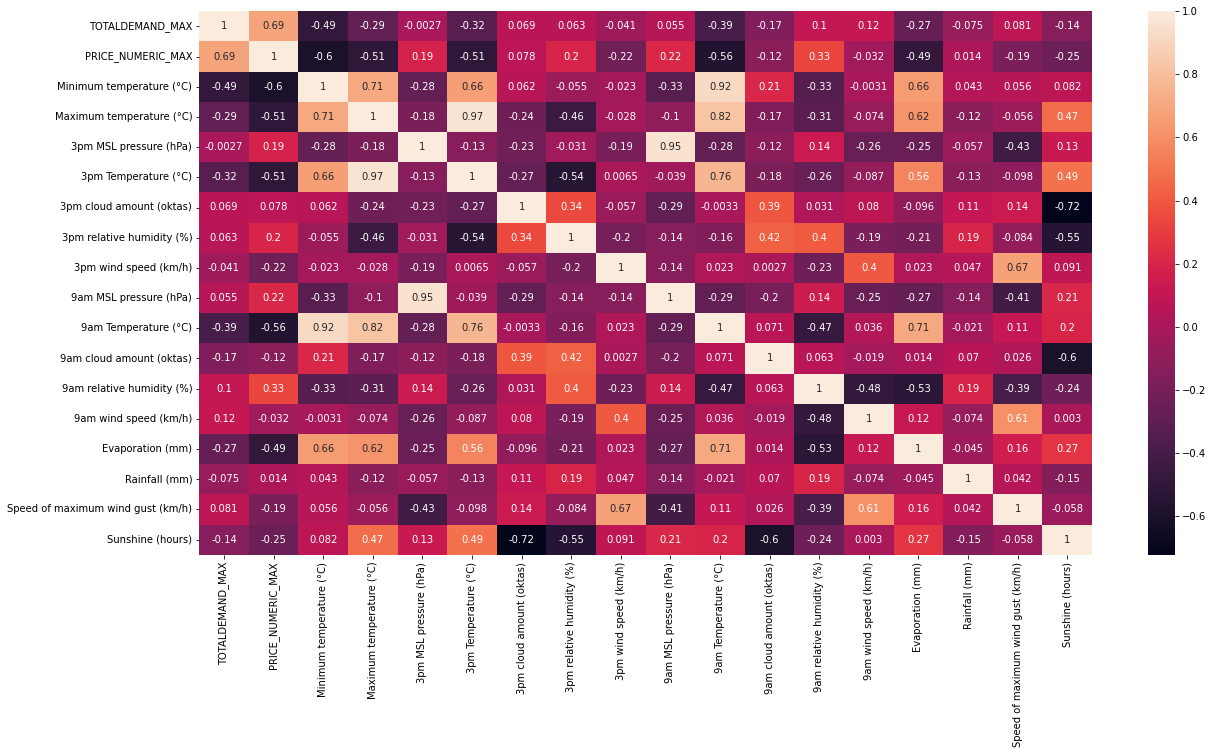

In [175]:
# Plotting the heatmap for all features
plt.figure(figsize = (20, 10))
sns.heatmap(dataset.corr(), annot = True);

<function matplotlib.pyplot.show(close=None, block=None)>

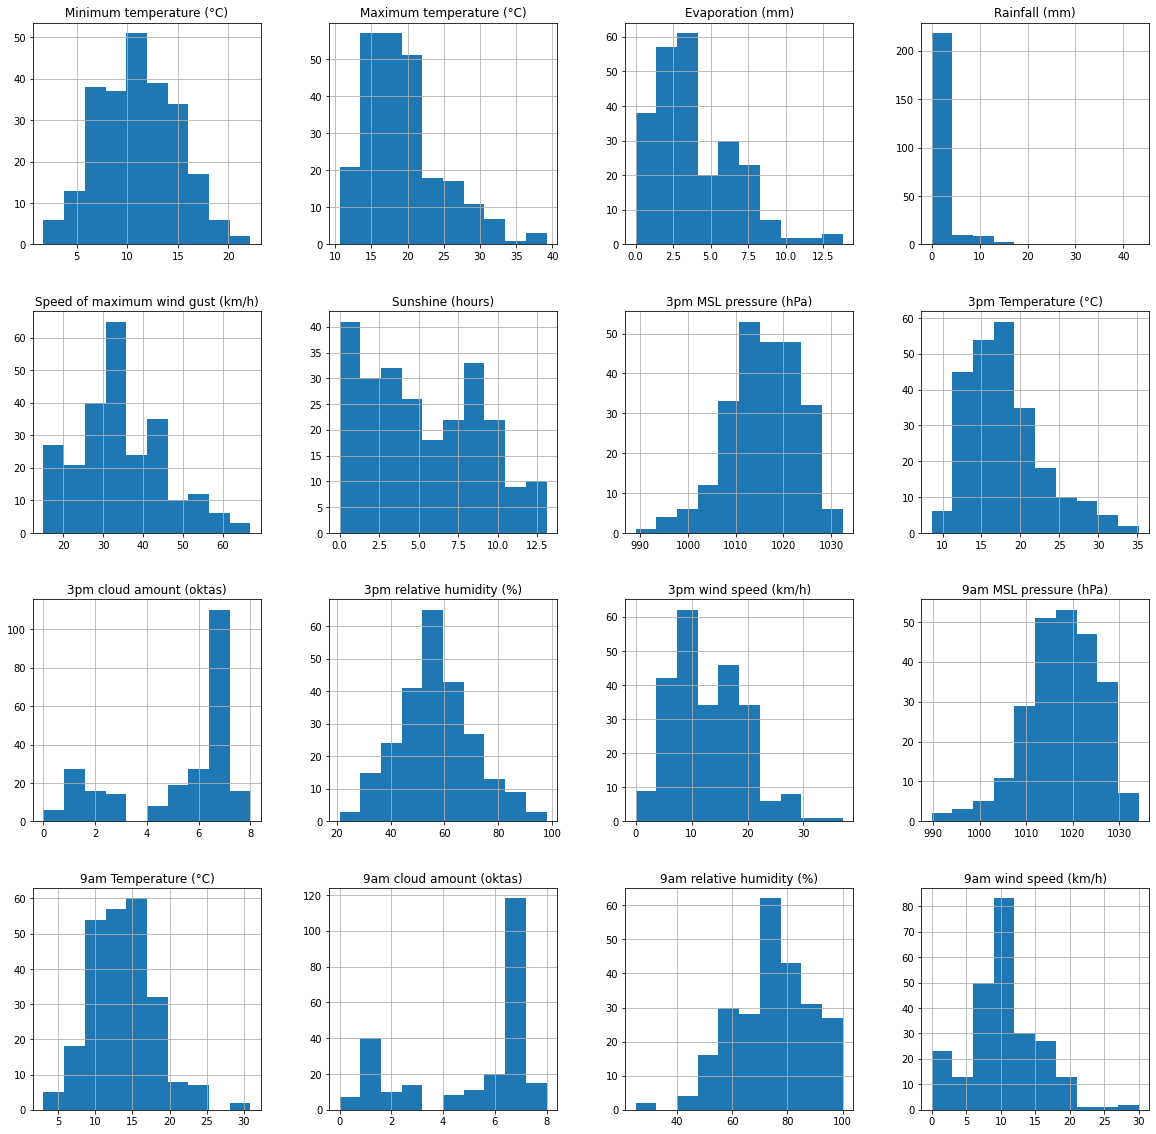

In [176]:
selected_features = dataset[['Minimum temperature (°C)', 'Maximum temperature (°C)','Evaporation (mm)', 'Rainfall (mm)', 'Speed of maximum wind gust (km/h)','Sunshine (hours)',
                    '3pm MSL pressure (hPa)', '3pm Temperature (°C)', '3pm cloud amount (oktas)', '3pm relative humidity (%)', '3pm wind speed (km/h)', \
                    '9am MSL pressure (hPa)', '9am Temperature (°C)', '9am cloud amount (oktas)', '9am relative humidity (%)', '9am wind speed (km/h)']]

selected_features.hist(figsize = (20,20))
plt.show

# 1st MODEL: Predict Max Daily Energy Demand 
### Feature Selection using f_regression

In [177]:
#UNIVARIATE SELECTION
from sklearn.model_selection import train_test_split
# Feature Extraction with Univariate Statistical Tests (f_regression)

# Select features (input)
X = dataset[['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)', 'Sunshine (hours)', 'Speed of maximum wind gust (km/h)', \
             '9am Temperature (°C)', '9am relative humidity (%)', '9am cloud amount (oktas)', '9am wind speed (km/h)', '9am MSL pressure (hPa)','3pm Temperature (°C)', \
             '3pm relative humidity (%)', '3pm cloud amount (oktas)', '3pm wind speed (km/h)', '3pm MSL pressure (hPa)']]

# What we want to predict (output)
y = dataset['TOTALDEMAND_MAX']

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [178]:
names = pd.DataFrame(X_train.columns)

model = SelectKBest(score_func = f_regression, k = 4)
results = model.fit(X, y)

#print (results.pvalues_)
results_df = pd.DataFrame(results.scores_)

#Concat and name columns
scored = pd.concat([names, results_df], axis = 1)
scored.columns = ['Feature', 'Score']
scored.sort_values(by = ['Score'], ascending = False)

,Feature,Score
0,Minimum temperature (°C),75.956143
6,9am Temperature (°C),43.607987
11,3pm Temperature (°C),28.451999
1,Maximum temperature (°C),22.087942
3,Evaporation (mm),18.367031
8,9am cloud amount (oktas),7.044857
4,Sunshine (hours),4.677220
9,9am wind speed (km/h),3.264896
7,9am relative humidity (%),2.501113
5,Speed of maximum wind gust (km/h),1.575561


## Linear Regression Model - Max Daily Energy Usage

In [179]:
# Choose the features (input)
X = dataset[['Minimum temperature (°C)', 'Evaporation (mm)', '3pm Temperature (°C)', 'Sunshine (hours)', 'Speed of maximum wind gust (km/h)', '3pm relative humidity (%)']]

# What we have to predict (output)
y = dataset['TOTALDEMAND_MAX']

# Splitting the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1)

# Generate the regression model (import .linear_model to use .LinearRegression() func)
lm = linear_model.LinearRegression()

# Create/ Produce the model: Fit training data into model
model = lm.fit(X_train, y_train)
display(model)

# Predict coefficient & intercept from linear regression model(lm)
print(f'Coefficients :{lm.coef_}')
print(f'Intercept :{lm.intercept_}')



LinearRegression()

Coefficients :[-139.84729718   36.83221445   38.74717067  -31.35585618    8.63365582
    4.76177465]
Intercept :6499.9268282605735


## Access how regression model is doing

In [180]:
# Evaluate r2 score
r2_test = lm.score(X_test, y_test) #on testing data
print(f'r2 test score :{r2_test}')


r2 test score :0.35115405151666657


35.1% of variation seen in these datapoints is explained by these features we have identified here.

### Equation used to predict the maximum daily energy use is:
5499.93(intercept) + (-139.85 * Minimum temperature) + (36.83 * Evaporation) + (-38.75 * 3pm Temperature (°C) + (-31.36 * Sunshine) + (8.63 * Speed of maximum wind gust) + (4.76 * 3pm relative humidity (%))

## How close these predictions are?

In [181]:
print(lm.predict(X_test.head())) # Predict values what we might think max demand should be
print(y_test.head()) # What we actually had based on the Y values

[5704.72445457 6545.45674744 6718.20483395 6230.02557589 5998.37658149]
67     5527.62
242    5779.56
205    6817.65
122    6183.00
89     5769.10
Name: TOTALDEMAND_MAX, dtype: float64


On 01/01/2021: Predicted max demand was 5704.72, its actual value is 5527.62

On 02/01/2021: Predicted max demand was 6548.46, its actual value is 5779.56 

On 03/01/2021: Predicted max demand was 6718.20, its actual value is 6817.65

On 04/01/2021: Predicted max demand was 6230.03, its actual value is 6183.00 

On 05/01/2021: Predicted max demand was 5998.38, its actual value is 5769.10 

This implies: There is not much difference between the predicted max demand and observed max demand, So, overall its a decently good model that we have.

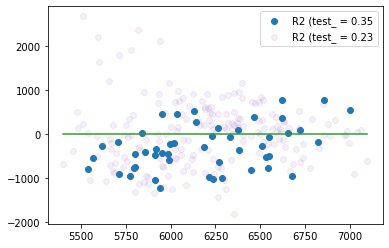

0.2271267457328704
0.35115405151666657


In [182]:
# Regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

from sklearn.metrics import r2_score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

import matplotlib.pyplot as plt
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

plt.scatter(y_test_pred, test_residuals, color='C0', label='R2 (test_ = {:.2}'.format(r2_test))
plt.scatter(y_train_pred, train_residuals, color='C4', label='R2 (test_ = {:.2}'.format(r2_train), alpha=0.1)
plt.plot([y_train_pred.min(),y_train_pred.max()], [0,0], color='C2')

plt.legend()
plt.show()

print(r2_train)
print(r2_test)

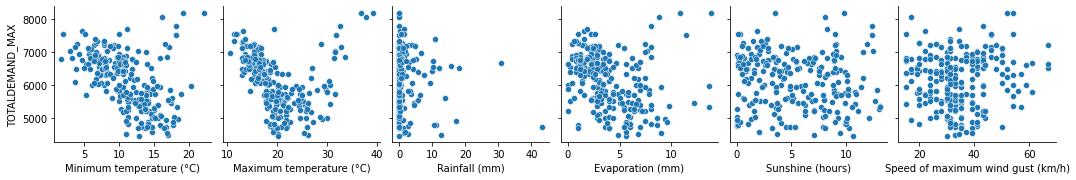

In [183]:
# Linear graphs for selected features
import seaborn as sns
sns.pairplot(dataset, 
             x_vars=['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)', 'Sunshine (hours)', 'Speed of maximum wind gust (km/h)'],
             y_vars=['TOTALDEMAND_MAX'])

plt.show()

# 2nd MODEL: Predict Max Daily Price Category
### Feature Selection using Chi Squared Test

In [184]:
# Choose the features (input)
X = dataset[['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)', 'Sunshine (hours)', 'Speed of maximum wind gust (km/h)', '9am Temperature (°C)', \
             '9am relative humidity (%)', '9am cloud amount (oktas)', '9am wind speed (km/h)', '9am MSL pressure (hPa)', '3pm Temperature (°C)', '3pm relative humidity (%)', \
             '3pm cloud amount (oktas)', '3pm wind speed (km/h)', '3pm MSL pressure (hPa)']]

# What we have to predict (output)
y = dataset['PRICE_NUMERIC_MAX']

# Instantiate
feature_selector = SelectKBest(chi2, k = 6)

 
# Perform selection
X_kbest = feature_selector.fit_transform(X, y)


print('Original number of features:', X.shape)
print('Reduced number of features:', X_kbest.shape)


Original number of features: (243, 16)
Reduced number of features: (243, 6)


# Kfold Cross-Validation for model prediction using KNN and Decision Tree

In [185]:
# Number of folds
k = 15
kf = KFold(n_splits = k, shuffle = True, random_state = 1)

acc_score = []
acc_score_dt = []

# Initiation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1)

for train_index, test_index in kf.split(X_kbest):
    
    # Perform the split for this fold
    X_train, X_test = X_kbest[train_index], X_kbest[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Scale the data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Impute missing values via mean imputation
    imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)
    
    # Train k-nn classifier
    knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
    dt = DecisionTreeClassifier(criterion = "entropy")
    
    # STEP 2: Fitting data / Training
    knn.fit(X_train, y_train)
    dt.fit(X_train, y_train)

    # STEP 3: Prediction / Test
    y_pred = knn.predict(X_test)
    y_pred_dt = dt.predict(X_test)
    
    # STEP 4: Evaluation
    acc_score.append(accuracy_score(y_test, y_pred))
    acc_score_dt.append(accuracy_score(y_test, y_pred_dt))
    

# Checking accuracy of the KNN model    
print('Accuracy of each fold for knn - {}'.format(acc_score))
avg_acc_score = sum(acc_score)/k
print('Avg accuracy for knn : {}'.format(avg_acc_score))

# Checking accuracy of the Decision Tree model 
print('Accuracy of each fold for Decision Tree- {}'.format(acc_score_dt))
avg_acc_score_dt = sum(acc_score_dt)/k
print('Avg accuracy for Decision Tree: {} '.format(avg_acc_score_dt))

Accuracy of each fold for knn - [0.5294117647058824, 0.47058823529411764, 0.47058823529411764, 0.5, 0.625, 0.5625, 0.375, 0.5, 0.4375, 0.625, 0.625, 0.5625, 0.625, 0.4375, 0.625]
Avg accuracy for knn : 0.5313725490196078
Accuracy of each fold for Decision Tree- [0.4117647058823529, 0.4117647058823529, 0.4117647058823529, 0.4375, 0.4375, 0.5625, 0.4375, 0.25, 0.3125, 0.5, 0.375, 0.625, 0.4375, 0.4375, 0.3125]
Avg accuracy for Decision Tree: 0.42401960784313725 


c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

#### Based on the above testing results, kfold = 15 gives the highest accuracy among the rest of the kfold testing values.

kfold = 5 : knn accuracy = 50.6% : DT accuracy : 40.3%

kfold = 10 : knn accuracy = 52.3% : DT accuracy : 40.3%

kfold = 15 : knn accuracy = 53.1% : DT accuracy : 41.5%

kfold = 100 : knn accuracy = 52.2% : DT accuracy : 39.5%



# Feature Selection using PCA with Kfold cross-validation

In [186]:
# Choose the features (input)
X = dataset[['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)', 'Sunshine (hours)', 'Speed of maximum wind gust (km/h)', '9am Temperature (°C)', \
             '9am relative humidity (%)', '9am cloud amount (oktas)', '9am wind speed (km/h)', '9am MSL pressure (hPa)', '3pm Temperature (°C)', '3pm relative humidity (%)', \
             '3pm cloud amount (oktas)', '3pm wind speed (km/h)', '3pm MSL pressure (hPa)']]

# What we have to predict (output)
y = dataset['PRICE_NUMERIC_MAX']

# Initiation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1)

# No of folds
k = 5
kf = KFold(n_splits = k, shuffle = True, random_state = 1)

acc_score = []
acc_score_dt = []

for train_index, test_index in kf.split(X):
    
    #Scale the data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    #Impute missing values via mean imputation
    imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)

    pca = PCA(n_components = 4)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    #Train k-nn classifier
    knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
    dt = DecisionTreeClassifier(criterion = "entropy", max_depth = 5)

    # STEP 2: Fitting data / Training
    knn.fit(X_train, y_train)
    dt.fit(X_train, y_train)

    # STEP 3: Prediction / Test
    y_pred = knn.predict(X_test)
    y_pred_dt = dt.predict(X_test)

    # STEP 4: Evaluation
    acc_score.append(accuracy_score(y_test, y_pred))
    acc_score_dt.append(accuracy_score(y_test, y_pred_dt))

print('Accuracy of each fold for knn - {}'.format(acc_score))
avg_acc_score = sum(acc_score)/k
print('Avg accuracy : {}'.format(avg_acc_score))

print('Accuracy of each fold for Decision Tree- {}'.format(acc_score_dt))
avg_acc_score_dt = sum(acc_score_dt)/k
print('Avg accuracy : {}'.format(avg_acc_score_dt))


Accuracy of each fold for knn - [0.5714285714285714, 0.5510204081632653, 0.5510204081632653, 0.5510204081632653, 0.5510204081632653]
Avg accuracy : 0.5551020408163264
Accuracy of each fold for Decision Tree- [0.5306122448979592, 0.3877551020408163, 0.5918367346938775, 0.3877551020408163, 0.4897959183673469]
Avg accuracy : 0.4775510204081632


c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

#### Based on the above testing results, knn results in more effective. 

kfold = 5 : knn accuracy = 55.5% : DT accuracy : 52.7%

kfold = 10 : knn accuracy = 55.3% : DT accuracy : 49.4%

kfold = 15 : knn accuracy = 55.2% : DT accuracy : 52.7%

kfold = 100 : knn accuracy = 55.1% : DT accuracy : 48.6%

# Data Visualisation

### MAX Energy Demand

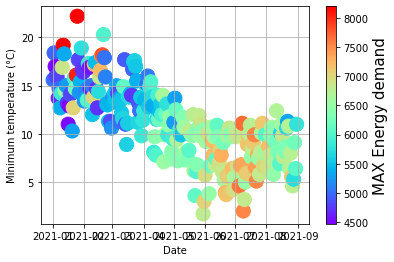

In [187]:
# Minimum temperature by Date
feature='Minimum temperature (°C)'

x = dataset['Date']
plt.xlabel('Date')

y = dataset[feature]
plt.ylabel(feature)

colors = dataset['TOTALDEMAND_MAX']

plt.scatter(x,y,s=200, c=colors,cmap="rainbow")
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label="MAX Energy demand", size=15)

plt.grid(True)

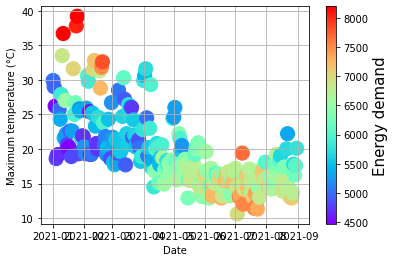

In [188]:
# Maximum temperature by Date
feature='Maximum temperature (°C)'

x = dataset['Date']
plt.xlabel('Date')

y = dataset[feature]
plt.ylabel(feature)

colors = dataset['TOTALDEMAND_MAX']

plt.scatter(x,y,s=200, c=colors,cmap="rainbow")
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label="Energy demand", size=15)

plt.grid(True)

## MAX Price Category

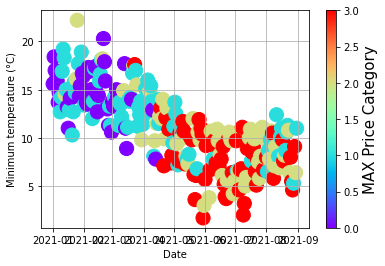

In [189]:
# Minimum temperature by Date
feature='Minimum temperature (°C)'

x = dataset['Date']
plt.xlabel('Date')

y = dataset[feature]
plt.ylabel(feature)

colors = dataset['PRICE_NUMERIC_MAX']

plt.scatter(x,y,s=200, c=colors,cmap="rainbow")
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label="MAX Price Category", size=15)

plt.grid(True)

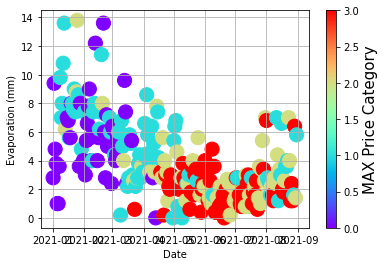

In [190]:
# Evaporation (mm) by Date
feature=\
'Evaporation (mm)'

x = dataset['Date']
plt.xlabel('Date')

y = dataset[feature]
plt.ylabel(feature)

colors = dataset['PRICE_NUMERIC_MAX']

plt.scatter(x,y,s=200, c=colors,cmap="rainbow")
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label="MAX Price Category", size=15)

plt.grid(True)